<a href="https://colab.research.google.com/github/katelyn-hucker/XAI_Final_Project/blob/main/SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable AI Final Project SHAP Implementation and Occluded Traffic Cone Analysis
### Katie Hucker (kh509)

In this notebook we have the implmentation code to run SHAP interpretations for Nuscenes traffic cone images. The SHAP interpretations are ran on a finetuned YOLOv8 model that was trained to detect the traffic cones within the dataset.

The first section defines the code: functions, process, the HOW we get the SHAP interpretations.

Then we compare 2 visibility level traffic cones: occluded (1-40% visible) and visible (80-100%). This is important to my Capstone groups analysis of how YOLO performs for very occluded traffic cones.

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Kild6vkcLObUuLfUw7teoZSu2-OIp2m0?usp=sharing)

# Section 1: SHAP Implementation

## Imports Installs and Mounting

In [ ]:
#installs uncomment if you need
!pip install ultralytics shap torch torchvision

In [ ]:
import torch
import numpy as np
import shap
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import os

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda:0


In [ ]:
# Imports and Configs
model_path = "/content/drive/MyDrive/Capstone/explainable models/best.pt"  # Path to your model
image_path = "/content/drive/MyDrive/Capstone/explainable models/images/n015-2018-07-18-11-41-49+0800__CAM_BACK__1531885800937525.jpg"  # Path to image
n_evals = 1000  # Number of SHAP evaluations # bigger number is more accurate
stride =  64 # this will downsample the image to 64 x 64 change if you want


In [ ]:
# Load model
print(f"Loading YOLOv8 model from: {model_path}")
model = YOLO(model_path)
model.to(device)
print(f"Model loaded with {len(model.names)} classes: {model.names}")

Loading YOLOv8 model from: /content/drive/MyDrive/Capstone/explainable models/best.pt
Model loaded with 1 classes: {0: 'traffic_cone'}


## Set-Up Functions

This function below predicts the traffic cones from YOLO and prepares the image to work with SHAP. Since we only have ONE class thats all we have to worry about. We are just looking for multiple traffic cone detections within an image.




In [ ]:
def cone_detect(image_path):
    """detect cone"""

    img = Image.open(image_path).convert("RGB")
    print(f"Original image size: {img.size}")

    #uses resize image function seen below
    img_resized = resize_image(img, size=(640, 640))
    img_np = np.array(img_resized)

    # inference
    results = model(img_np, conf=0.01)

    # print results
    num_detections = len(results[0].boxes)
    print(f"Detected {num_detections} traffic cones")
    print("Confidence scores:", [f"{conf:.3f}" for conf in results[0].boxes.conf.tolist()])

    return results, img_np

YOLO and SHAP require a specific set-up this function resizes the image to a size of 640x640.

In [ ]:
def resize_image(img, size=(640, 640)):

    width, height = size
    new_width = (width // stride) * stride
    new_height = (height // stride) * stride

    img_resized = img.resize((new_width, new_height), Image.LANCZOS)
    print(f"Image resized to {new_width}x{new_height}")

    return img_resized

## SHAP Functions

This function is a prediction wrapper compatible with SHAP for interpreting the YOLO traffic cone detections. The function performs inference on the provided image using the model provided. For each image, it keeps track of the confidence scores, storing them in a SHAP compatible tensor. Since we are only interested in one potential class: traffic cones — this function simplifies output processing by summing the detection confidences for that single class across each image in the batch.

In [ ]:
def create_prediction_function():
    """Create a prediction function for SHAP"""
    def predict_fn(images):

        if isinstance(images, np.ndarray):
            #normalization
            if images.max() > 1.0:
                images = images.astype(np.float32) / 255.0 #if values are in the 0–255 range, scale them to 0–1

            images = torch.tensor(images).float()

        #add batch dimension
        #Claude Sonnet 3.7 generated this line at 4/18/2025
        if images.dim() == 3:
            images = images.unsqueeze(0)

        # Convert to NCHW format if needed
         #Claude Sonnet 3.7 generated this line at 4/18/2025
        if images.shape[-1] == 3:  # If NHWC format
            images = images.permute(0, 3, 1, 2)  # Convert to NCHW

        # inference
        with torch.no_grad():
            results = model(images.to(device), conf=0.01)

        # output
        batch_size = images.shape[0]
        output = torch.zeros((batch_size, len(model.names))).to(device)

        #Claude Sonnet 3.7 generated this for loop at 4/18/2025
        for i, res in enumerate(results):
            boxes = res.boxes
            if len(boxes) > 0:
                for conf, cls_id in zip(boxes.conf, boxes.cls.int()):
                    output[i, cls_id.item()] += conf.item()

        return output

    return predict_fn

This function generates SHAP values to explain YOLO-based traffic cone detections within a given image. It begins by normalizing the input image. It then calls the prediction wrapper function we defined above. We create a blurring mask for the SHAP interpretation. SHAP needs a way to simulate what the model would predict if certain parts of the image were missing or unknown. SHAP replaces them with a blurred version of the image. This method helps keep the modified image looking natural and avoids introducing artifacts that the model might misinterpret. We create the shap explainer object. Which will then, compute the SHAP values for the traffic cone in the image, evaluating how different image regions contribute to the detection output.

In [ ]:
def generate_shap_values(results, img_np):
    """Generate SHAP values for the traffic cone detector"""

    # normalize again
    img_normalized = img_np.astype(np.float32) / 255.0

    #call function defined aboe
    predict_fn = create_prediction_function()

    # mask the image
    masker = shap.maskers.Image("blur(16,16)", img_normalized.shape)

    # Create explainer
    #https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html
    explainer = shap.Explainer(predict_fn, masker, output_names=list(model.names.values()))

    print(f"Generating SHAP explanation with {n_evals} evaluations...")

    shap_values = explainer( #used above link to find optimal params
        np.expand_dims(img_normalized, 0),
        max_evals=n_evals,
        batch_size=10,
        outputs=[0]
    )

    print("SHAP values generated")

    return {
        "shap_values": shap_values,
        "shap_img": img_normalized,
        "detection_results": results
    }


## Plotting Functions

In [ ]:
def plot_detection(results):
    """YOLO Output"""
    plt.figure(figsize=(10, 6))
    plt.imshow(results[0].plot())
    plt.title(f"YOLOv8 Detection ({len(results[0].boxes)} traffic cones)")
    plt.axis('off')
    plt.show()

def plot_standard_shap(shap_data):
    """Use built in SHAP plot"""
    # https://shap.readthedocs.io/en/latest/generated/shap.plots.image.html
    shap_img = shap_data["shap_img"]
    shap_values = shap_data["shap_values"]

    plt.figure(figsize=(10, 6))

    shap.plots.image(
        shap_values,
        pixel_values=np.expand_dims(shap_img, 0),
        labels=["Traffic Cone"],
        width=18,
        labelpad=5.0,
        vmax=abs(shap_values.values).max(),
        show=True
    )

def plot_heatmap_overlay(shap_data):
    """Make a clearer heatmap"""

    shap_img = shap_data["shap_img"]
    shap_values = shap_data["shap_values"]
    shap_vals = shap_values.values[0, :, :, :, 0]

    #heatmap calculations
    #Claude Sonnet 3.7 was used to generate the heatmap calculation 4/18/2025
    shap_sum = np.abs(shap_vals).sum(axis=-1)
    shap_norm = shap_sum / shap_sum.max()

    plt.figure(figsize=(10, 6))

    plt.imshow(shap_img)

    plt.imshow(shap_norm, cmap='hot', alpha=0.5)
    plt.colorbar(label='SHAP Importance')
    plt.title("SHAP Importance Heatmap")
    plt.axis('off')
    plt.show()

    return shap_norm

def plot_combined_visualization(shap_data, shap_norm):
    """Plot comparison"""

    shap_img = shap_data["shap_img"]
    results = shap_data["detection_results"]


    plt.figure(figsize=(14, 6))


    plt.subplot(1, 2, 1)
    plt.imshow(results[0].plot())
    plt.title("YOLOv8 Detection")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(shap_img)
    plt.imshow(shap_norm, cmap='hot', alpha=0.5)
    plt.title("SHAP Importance Heatmap")
    plt.axis('off')
    plt.show()

## Main Function

In [ ]:
results, img_np = cone_detect(image_path)

Original image size: (1600, 900)
Image resized to 640x640

0: 640x640 2 traffic_cones, 18.3ms
Speed: 5.8ms preprocess, 18.3ms inference, 156.3ms postprocess per image at shape (1, 3, 640, 640)
Detected 2 traffic cones
Confidence scores: ['0.462', '0.310']


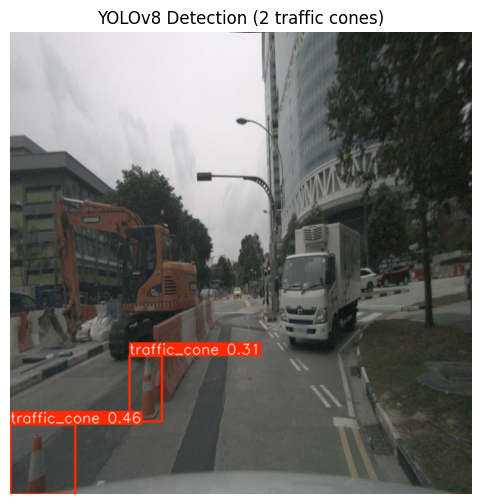

In [ ]:
plot_detection(results)

In [ ]:
shap_data = generate_shap_values(results, img_np)

Generating SHAP explanation with 1000 evaluations...

0: 640x640 1 traffic_cone, 76.8ms
Speed: 0.0ms preprocess, 76.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 traffic_cones, 16.9ms
Speed: 0.0ms preprocess, 16.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 8 traffic_cones, 33.5ms
1: 640x640 1 traffic_cone, 33.5ms
Speed: 0.0ms preprocess, 33.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 traffic_cones, 20.5ms
1: 640x640 2 traffic_cones, 20.5ms
2: 640x640 2 traffic_cones, 20.5ms
3: 640x640 2 traffic_cones, 20.5ms
4: 640x640 7 traffic_cones, 20.5ms
5: 640x640 5 traffic_cones, 20.5ms
6: 640x640 1 traffic_cone, 20.5ms
7: 640x640 1 traffic_cone, 20.5ms
Speed: 0.0ms preprocess, 20.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 traffic_cones, 21.2ms
1: 640x640 9 traffic_cones, 21.2ms
2: 640x640 4 traffic_cones, 21.2ms
3: 640x640 5 traffic_cones, 21.2m

  0%|          | 0/998 [00:00<?, ?it/s]


0: 640x640 3 traffic_cones, 20.6ms
1: 640x640 4 traffic_cones, 20.6ms
2: 640x640 6 traffic_cones, 20.6ms
3: 640x640 7 traffic_cones, 20.6ms
4: 640x640 2 traffic_cones, 20.6ms
5: 640x640 2 traffic_cones, 20.6ms
6: 640x640 4 traffic_cones, 20.6ms
7: 640x640 3 traffic_cones, 20.6ms
8: 640x640 3 traffic_cones, 20.6ms
9: 640x640 4 traffic_cones, 20.6ms
Speed: 0.0ms preprocess, 20.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 traffic_cones, 20.4ms
1: 640x640 3 traffic_cones, 20.4ms
2: 640x640 1 traffic_cone, 20.4ms
3: 640x640 1 traffic_cone, 20.4ms
4: 640x640 1 traffic_cone, 20.4ms
5: 640x640 2 traffic_cones, 20.4ms
6: 640x640 8 traffic_cones, 20.4ms
7: 640x640 12 traffic_cones, 20.4ms
8: 640x640 9 traffic_cones, 20.4ms
9: 640x640 5 traffic_cones, 20.4ms
Speed: 0.0ms preprocess, 20.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 9 traffic_cones, 20.6ms
1: 640x640 10 traffic_cones, 20.6ms
2: 640x640 5 traffic_cones, 20.6ms

PartitionExplainer explainer: 2it [00:36, 36.90s/it]               

SHAP values generated


<Figure size 1000x600 with 0 Axes>

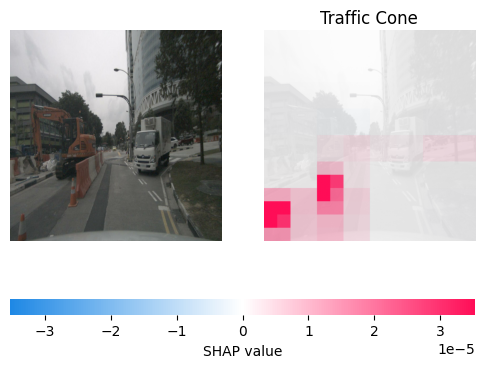

In [ ]:
# Plot standard SHAP visualization
plot_standard_shap(shap_data)



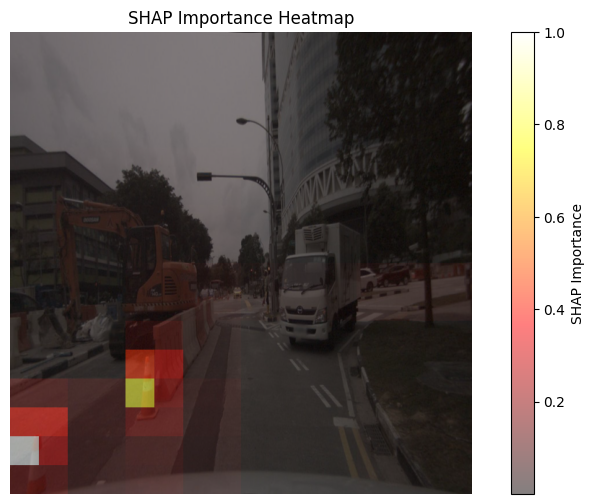

In [ ]:
# Plot heatmap overlay
shap_norm = plot_heatmap_overlay(shap_data)

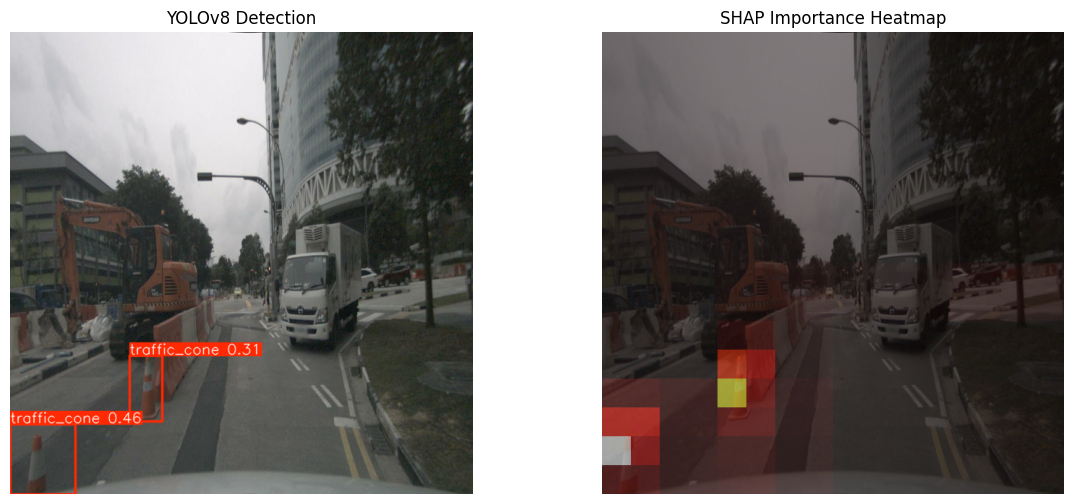

In [ ]:

plot_combined_visualization(shap_data, shap_norm)

# Section 2: Occlusion Cone Analysis and Experimentation

## The Visible Cones

These cones are labeled as 80-100% visible. Let's see what SHAP says...

In [ ]:
# New image

image_path = "/content/drive/MyDrive/Capstone/explainable models/images/n008-2018-08-01-15-16-36-0400__CAM_BACK_RIGHT__1533151427028113.jpg"  # Path to image
n_evals = 5000  # Number of SHAP evaluations # bigger number is more accurate
stride =  64 # this will downsample the image to 64 x 64 change if you want

In [ ]:
results, img_np = cone_detect(image_path=image_path)

Original image size: (1600, 900)
Image resized to 640x640

0: 640x640 3 traffic_cones, 19.6ms
Speed: 2.3ms preprocess, 19.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Detected 3 traffic cones
Confidence scores: ['0.193', '0.065', '0.021']


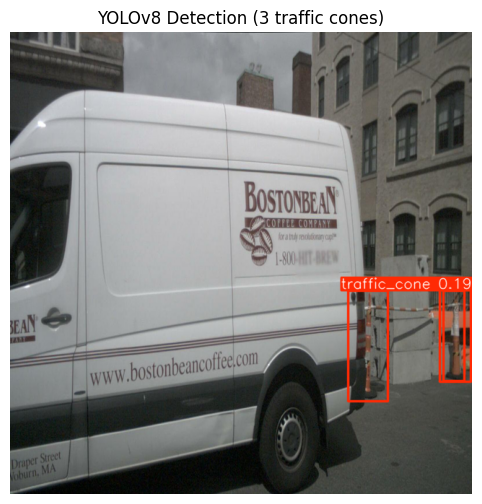

In [ ]:
plot_detection(results)

In [ ]:
shap_data = generate_shap_values(results, img_np)

Generating SHAP explanation with 5000 evaluations...

0: 640x640 (no detections), 17.6ms
Speed: 1.8ms preprocess, 17.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 traffic_cones, 16.8ms
Speed: 0.0ms preprocess, 16.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 traffic_cones, 16.0ms
1: 640x640 (no detections), 16.0ms
Speed: 0.0ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 traffic_cones, 19.9ms
1: 640x640 (no detections), 19.9ms
2: 640x640 5 traffic_cones, 19.9ms
3: 640x640 (no detections), 19.9ms
4: 640x640 5 traffic_cones, 19.9ms
5: 640x640 5 traffic_cones, 19.9ms
6: 640x640 (no detections), 19.9ms
7: 640x640 (no detections), 19.9ms
Speed: 0.0ms preprocess, 19.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 20.4ms
1: 640x640 4 traffic_cones, 20.4ms
2: 640x640 (no detections), 20.4ms
3: 640x640 3 traffic_cones, 2

  0%|          | 0/4998 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1: 640x640 4 traffic_cones, 20.5ms
2: 640x640 2 traffic_cones, 20.5ms
3: 640x640 (no detections), 20.5ms
4: 640x640 3 traffic_cones, 20.5ms
5: 640x640 1 traffic_cone, 20.5ms
6: 640x640 2 traffic_cones, 20.5ms
7: 640x640 2 traffic_cones, 20.5ms
8: 640x640 3 traffic_cones, 20.5ms
9: 640x640 4 traffic_cones, 20.5ms
Speed: 0.0ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 traffic_cones, 20.5ms
1: 640x640 6 traffic_cones, 20.5ms
2: 640x640 2 traffic_cones, 20.5ms
3: 640x640 (no detections), 20.5ms
4: 640x640 5 traffic_cones, 20.5ms
5: 640x640 4 traffic_cones, 20.5ms
6: 640x640 3 traffic_cones, 20.5ms
7: 640x640 3 traffic_cones, 20.5ms
8: 640x640 2 traffic_cones, 20.5ms
9: 640x640 1 traffic_cone, 20.5ms
Speed: 0.0ms preprocess, 20.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 traffic_cones, 20.4ms
1: 640x640 3 traffic_cones, 20.4ms
2: 640x640 6 traffic

PartitionExplainer explainer: 2it [02:50, 170.67s/it]              

SHAP values generated


<Figure size 1000x600 with 0 Axes>

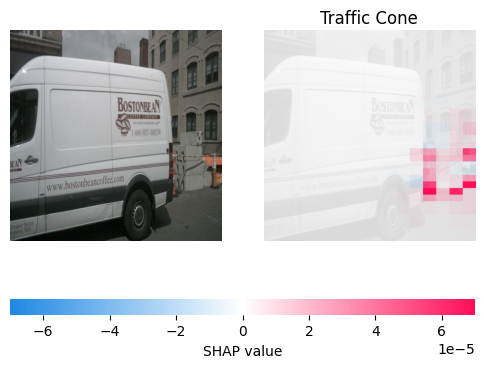

In [ ]:
plot_standard_shap(shap_data)

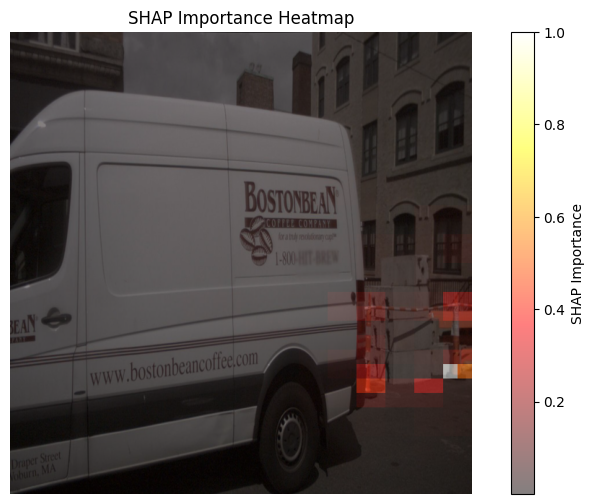

In [ ]:
shap_norm = plot_heatmap_overlay(shap_data)

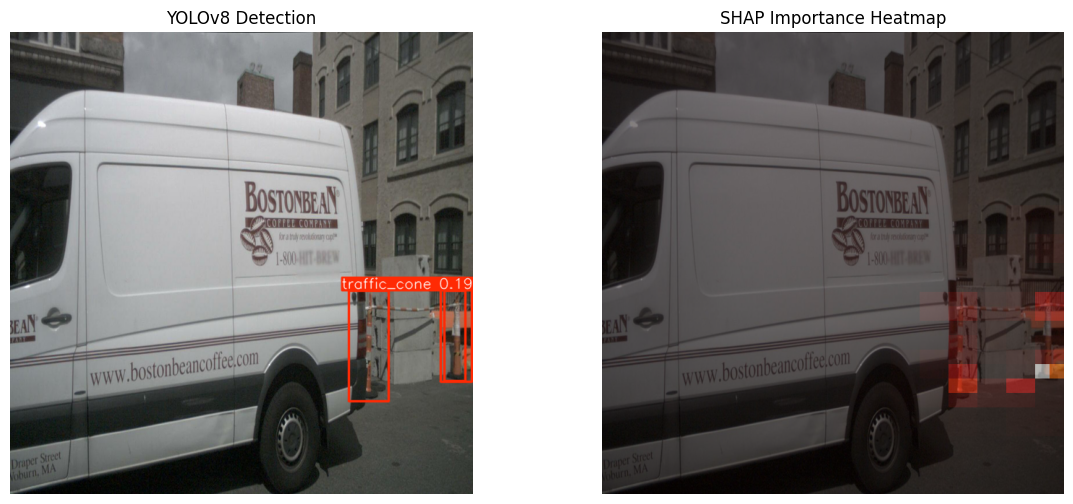

In [ ]:
plot_combined_visualization(shap_data, shap_norm)

### Visible Cone for SHAP Discussion

For the two cones which were labeled as very visible in the category bin of 80-100%, we see the SHAP heatmap does focusin on them. Specifically the bottom of the cone is shows a stronger response. I think it is really interesting that the barrier in between the two cones is not focus on at all -- showing that SHAP IS looking at the cones and trying to avoid other things.

However we see the colorbars in the first two figures which shows a small numeric response in general but within this scale it shows a good enough response to be 'strong'

## Occluded Cone

Here we look at a cone which as labeled as 1-40% visible in the Nuscenes dataset.

In [ ]:
#new image
image_path = "/content/drive/MyDrive/Capstone/explainable models/images/n015-2018-07-11-11-54-16+0800__CAM_BACK_LEFT__1531281493197423.jpg"  # Path to image
n_evals = 5000  # Number of SHAP evaluations # bigger number is more accurate
stride =  64 # this will downsample the image to 64 x 64 change if you want

In [ ]:
results, img_np = cone_detect(image_path=image_path)

Original image size: (1600, 900)
Image resized to 640x640

0: 640x640 (no detections), 20.6ms
Speed: 3.4ms preprocess, 20.6ms inference, 9.7ms postprocess per image at shape (1, 3, 640, 640)
Detected 0 traffic cones
Confidence scores: []


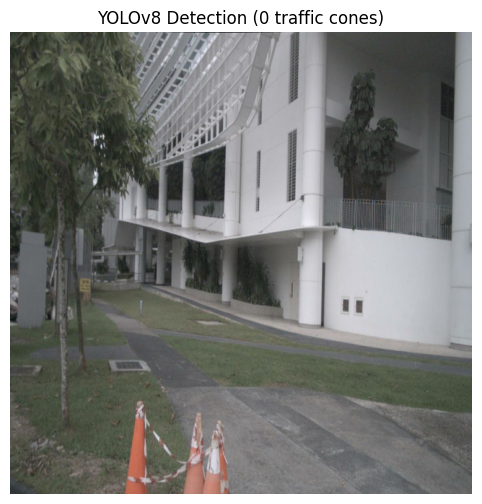

In [ ]:
plot_detection(results)

In [ ]:
shap_data = generate_shap_values(results, img_np)

Generating SHAP explanation with 5000 evaluations...

0: 640x640 1 traffic_cone, 18.9ms
Speed: 0.0ms preprocess, 18.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 traffic_cones, 16.5ms
Speed: 0.0ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 traffic_cones, 16.1ms
1: 640x640 (no detections), 16.1ms
Speed: 0.0ms preprocess, 16.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 19.7ms
1: 640x640 7 traffic_cones, 19.7ms
2: 640x640 1 traffic_cone, 19.7ms
3: 640x640 6 traffic_cones, 19.7ms
4: 640x640 6 traffic_cones, 19.7ms
5: 640x640 6 traffic_cones, 19.7ms
6: 640x640 1 traffic_cone, 19.7ms
7: 640x640 (no detections), 19.7ms
Speed: 0.0ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 traffic_cones, 20.4ms
1: 640x640 (no detections), 20.4ms
2: 640x640 7 traffic_cones, 20.4ms
3: 640x640 (no detections), 20.4

  0%|          | 0/4998 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1: 640x640 6 traffic_cones, 20.5ms
2: 640x640 7 traffic_cones, 20.5ms
3: 640x640 6 traffic_cones, 20.5ms
4: 640x640 10 traffic_cones, 20.5ms
5: 640x640 8 traffic_cones, 20.5ms
6: 640x640 8 traffic_cones, 20.5ms
7: 640x640 7 traffic_cones, 20.5ms
8: 640x640 3 traffic_cones, 20.5ms
9: 640x640 3 traffic_cones, 20.5ms
Speed: 0.0ms preprocess, 20.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 traffic_cones, 20.6ms
1: 640x640 6 traffic_cones, 20.6ms
2: 640x640 6 traffic_cones, 20.6ms
3: 640x640 6 traffic_cones, 20.6ms
4: 640x640 8 traffic_cones, 20.6ms
5: 640x640 10 traffic_cones, 20.6ms
6: 640x640 2 traffic_cones, 20.6ms
7: 640x640 1 traffic_cone, 20.6ms
8: 640x640 7 traffic_cones, 20.6ms
9: 640x640 7 traffic_cones, 20.6ms
Speed: 0.0ms preprocess, 20.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 traffic_cones, 20.5ms
1: 640x640 6 traffic_cones, 20.5ms
2: 640x640 6 traf

PartitionExplainer explainer: 2it [02:51, 171.07s/it]              

SHAP values generated


<Figure size 1000x600 with 0 Axes>

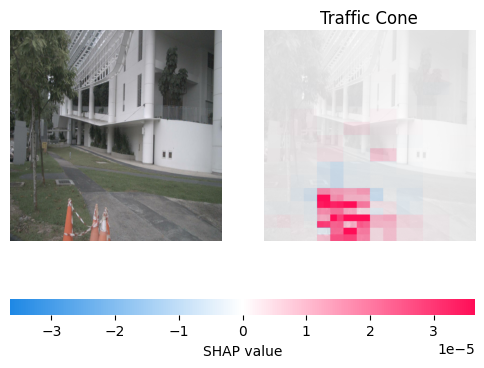

In [ ]:
plot_standard_shap(shap_data)

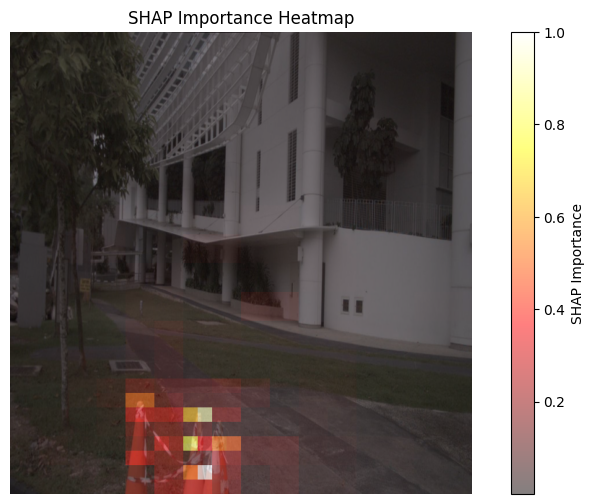

In [ ]:
shap_norm = plot_heatmap_overlay(shap_data)

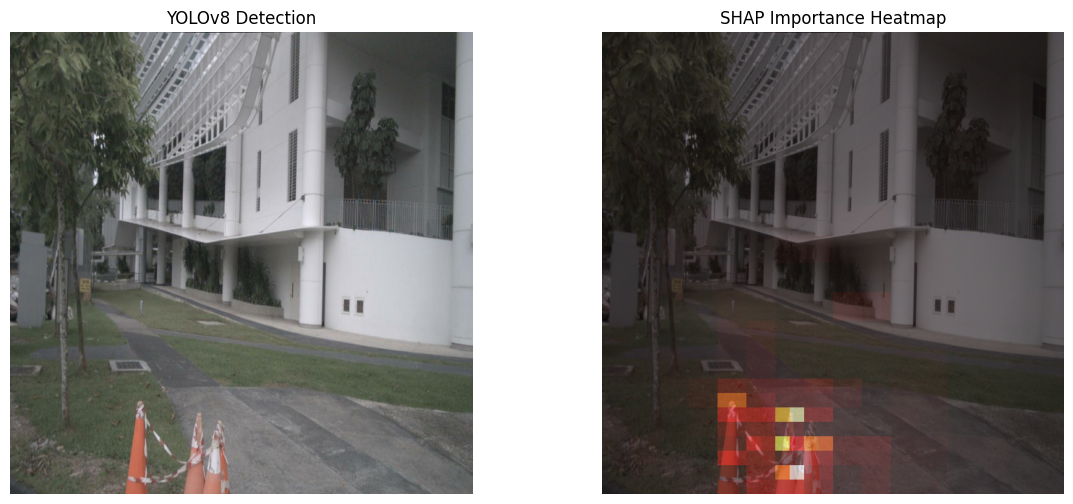

In [ ]:
plot_combined_visualization(shap_data, shap_norm)

### Occluded Cone for SHAP Discussion

This cones were labeled as 1-40% visible, so very occluded. We see that YOLO fails to even detect them in this run of YOLO (however in previous runs YOLO did detect). BUT this makes it more interesting in that, we see SHAP still is looking at the cones! The color bar shows about HALF as much as the visible cone for the range. So we can interpret we at least need a SHAP greater than (3 * 1e-6 ) to get a detection. It also does not seem as much accurate in a specific location. We see some response on the grassy background and the white building. However, the top of the cone does seem to show some stronger response very mild though.

## SHAP Discussion

Overall, SHAP does well in showing us where the cone is even if YOLO failed to 'detect' but the numbers and response are very minimal for the occluded cone whencompared to the visible cone. In addition, we see the visible cone image the SHAP response avoids non cone objects even though it is directly inbetween, this is not as clear in the occluded cone image. With some of the grassy middl between the cones shows response. The analysis for 5000 samples on the L4 GPU took under 5 mins for each run which is pretty quick for a wide range of data. I would recommend further analysis in the 'stride' function to see if greater denser super pixels would aid in stronger SHAP response.

## References for SHAP implementation

https://www.nuscenes.org/

https://docs.ultralytics.com/models/yolov8/

https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Explain%20MobilenetV2%20using%20the%20Partition%20explainer%20%28PyTorch%29.html


https://shap.readthedocs.io/en/latest/generated/shap.plots.image.html

https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html